# 01b_embedding_autoencoder

In this notebook, an autoencoder is trained on our training data textual description embeddings, reducing the embeddings to a bottlenecked 2-dimenstion latent space.

The purpose of this will be convert our textual project descriptions to two additional features we can use while training and testing our model.

In [232]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot
import matplotlib.pylab as plt 
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Reshape
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam, SGD

In [8]:
file_path = '../data/interim/embeddings_uncased_L-2_H-128_A-2.csv'
    
if os.path.isfile(file_path):
    print("OK - path points to file.")
else:
    print("ERROR - check the 'file_path' and ensure it points to the source file.")

OK - path points to file.


In [9]:
data_embed = pd.read_csv(file_path)
data_full = pd.read_csv('../data/interim/Capital_Projects_clean.csv') 

In [10]:
# entries
print(f"Number of dataset records: {len(data_embed)}")

# num projects
print(f"Number of unique projects in dataset: {len(data_embed['PID'].unique())}")

Number of dataset records: 681
Number of unique projects in dataset: 378


In [11]:
data_embed.info()

data_embed.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681 entries, 0 to 680
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   PID        681 non-null    int64 
 1   embedding  681 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.8+ KB


,PID,embedding
0,3,"-0.13848002, 1.4585834, -6.7887063, 0.06124621..."
1,7,"-0.1312232, 1.1953796, -6.7208276, 0.061367474..."
2,18,"0.0988148, 1.6704051, -6.5728025, 0.068978384,..."


In [52]:
# dedupe dataframe by keeping first occurance of each PID
data_embed = data_embed.copy().drop_duplicates(subset='PID', keep='first')

In [53]:
# entries
print(f"Number of dataset records: {len(data_embed)}")

# num projects
print(f"Number of unique projects in dataset: {len(data_embed['PID'].unique())}")

Number of dataset records: 378
Number of unique projects in dataset: 378


In [55]:
pid_array = data_embed['PID'].values
embed_array = np.vstack(
    data_embed['embedding'].str.split(',').apply(lambda x: np.array(x).astype(float)).values
)

embed_array.shape, pid_array.shape

((378, 512), (378,))

# Define Autoencoder

In [150]:


# define function for plotting train vs val loss history by epoch

def plot_history(history, title, val_name='validation (TEST)', loss_type='MSE'):
    """Plot training and validation loss using keras history object
    """
    n_epochs = len(history.history['loss'])
    x_vals = np.arange(1, n_epochs+1)
    
    # adjust interval of x_ticks based on n_epochs
    if n_epochs<40:
        x_ticks = x_vals
    elif n_epochs<140:
        x_ticks = np.arange(0, n_epochs+1, 5)
    else:
        x_ticks = np.arange(0, n_epochs+1, 10)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))

    plt.suptitle('{}'.format(title), fontsize=20)
        
    ax.plot(x_vals, history.history['loss'], 'k--', label='training')
    ax.plot(x_vals, history.history['val_loss'], 'k-', label=val_name)
    ax.set_xlabel('epoch', fontsize=14)
    ax.set_ylabel('loss ({})'.format(loss_type), fontsize=14)
    ax.set_xticks(x_ticks)
    ax.grid(':', alpha=0.4)
    ax.tick_params(labelsize=12)        
    
    plt.legend(fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, .9])
    plt.show()



In [218]:
# set input and encoded latent dimensions
input_dim = embed_array.shape[1]
encoding_dim = 2

# define encoder model
input_layer = Input(shape=(input_dim,))
# encoded = Dense(encoding_dim*256, activation='relu', use_bias=True)(input_layer)
encoded = Dense(encoding_dim*64, activation='relu', use_bias=True)(input_layer)
encoded = Dropout(rate=0.5)(encoded)
encoded = Dense(encoding_dim*16, activation='relu', use_bias=True)(encoded)
encoded = Dropout(rate=0.5)(encoded)
encoded = Dense(encoding_dim*4, activation='relu', use_bias=True)(encoded)
encoded = Dropout(rate=0.5)(encoded)
encoded = Dense(encoding_dim, activation='relu', use_bias=True)(encoded)
encoded = Dropout(rate=0.5)(encoded)
encoder = Model(input_layer, encoded, name='encoder' )

# define decoder model
latent_input = Input(shape=(encoding_dim,))
decoded = Dense(encoding_dim*4, activation='relu', use_bias=True)(latent_input)
encoded = Dropout(rate=0.5)(encoded)
decoded = Dense(encoding_dim*16, activation='relu', use_bias=True)(decoded)
encoded = Dropout(rate=0.5)(encoded)
decoded = Dense(encoding_dim*64, activation='relu', use_bias=True)(decoded)
decoded = Dropout(rate=0.5)(decoded)
# decoded = Dense(encoding_dim*256, activation='relu', use_bias=True)(decoded)
decoded = Dense(input_dim, activation='linear', use_bias=True)(decoded)
decoder = Model(latent_input, decoded, name='decoder')

# define full non-linear autoencoder model
ae = Sequential(
    [
        encoder,
        decoder,
    ], name='ae'
)

# set loss, optimizer, and compile model
loss = tf.keras.losses.mean_squared_error
optimizer = Adam(lr=0.0001)

ae.compile(
    loss=loss,
    optimizer=optimizer
)

# print summaries of each model
print('\nTHE ENCODER MODEL:\n')
encoder.summary()
print('\n\nTHE DECODER MODEL:\n')
decoder.summary()
print('\n\nTHE NON-LINEAR AUTOENCODER (AE) MODEL:\n')
ae.summary()
print('\n')



THE ENCODER MODEL:

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        [(None, 512)]             0         
_________________________________________________________________
dense_316 (Dense)            (None, 128)               65664     
_________________________________________________________________
dropout_51 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_317 (Dense)            (None, 32)                4128      
_________________________________________________________________
dropout_52 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_318 (Dense)            (None, 8)                 264       
_________________________________________________________________
dropout_53 (Dropout)         (None, 8)

In [314]:
# set input and encoded latent dimensions
input_dim = embed_array.shape[1]
encoding_dim = 1

# define encoder model
input_layer = Input(shape=input_dim)
encoded = Dense(encoding_dim*256, activation='relu', use_bias=True)(input_layer)
encoded = Dense(encoding_dim*64, activation='relu', use_bias=True)(input_layer)
# encoded = Dropout(rate=0.5)(encoded)
encoded = Dense(encoding_dim*16, activation='relu', use_bias=True)(encoded)
# encoded = Dropout(rate=0.5)(encoded)
encoded = Dense(encoding_dim*4, activation='relu', use_bias=True)(encoded)
# encoded = Dropout(rate=0.5)(encoded)
encoded = Dense(encoding_dim, activation='linear', use_bias=True)(encoded)
# encoded = Dropout(rate=0.5)(encoded)
encoder = Model(input_layer, encoded, name='encoder' )

# define decoder model
latent_input = Input(shape=(encoding_dim,))
decoded = Dense(encoding_dim*4, activation='relu', use_bias=True)(latent_input)
# encoded = Dropout(rate=0.5)(encoded)
decoded = Dense(encoding_dim*16, activation='relu', use_bias=True)(decoded)
# encoded = Dropout(rate=0.5)(encoded)
decoded = Dense(encoding_dim*64, activation='relu', use_bias=True)(decoded)
# decoded = Dropout(rate=0.5)(decoded)
decoded = Dense(encoding_dim*256, activation='relu', use_bias=True)(decoded)
decoded = Dense(input_dim, activation='linear', use_bias=True)(decoded)
decoder = Model(latent_input, decoded, name='decoder')

# define full non-linear autoencoder model
ae = Sequential(
    [
        encoder,
        decoder,
    ], name='ae'
)

# set loss, optimizer, and compile model
loss = tf.keras.losses.mean_squared_error
optimizer = Adam(lr=0.001)

ae.compile(
    loss=loss,
    optimizer=optimizer
)

# print summaries of each model
print('\nTHE ENCODER MODEL:\n')
encoder.summary()
print('\n\nTHE DECODER MODEL:\n')
decoder.summary()
print('\n\nTHE NON-LINEAR AUTOENCODER (AE) MODEL:\n')
ae.summary()
print('\n')



THE ENCODER MODEL:

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_110 (InputLayer)       [(None, 512)]             0         
_________________________________________________________________
dense_388 (Dense)            (None, 64)                32832     
_________________________________________________________________
dense_389 (Dense)            (None, 16)                1040      
_________________________________________________________________
dense_390 (Dense)            (None, 4)                 68        
_________________________________________________________________
dense_391 (Dense)            (None, 1)                 5         
Total params: 33,945
Trainable params: 33,945
Non-trainable params: 0
_________________________________________________________________


THE DECODER MODEL:

Model: "decoder"
_____________________________________________________________

In [315]:
%%time

# set my parameters for training the model
verbose = 1
epochs = 100 # note my use of early-stopping to end training at suitable epoch
batch_size = 16

# callback for early stopping when epochs fail to yield val_loss improvements
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=1,
    restore_best_weights=True
)


# Fit model using x_test as validation data and self for measuring loss
ae_history = ae.fit(
    x=embed_array,
    y=embed_array,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[callback],
    validation_data=(embed_array, embed_array),
    verbose=verbose
)

Train on 378 samples, validate on 378 samples
Epoch 1/100
378/378 [==============================] - 1s 3ms/sample - loss: 1.5627 - val_loss: 0.6870
Epoch 2/100
378/378 [==============================] - 0s 722us/sample - loss: 0.4239 - val_loss: 0.3108
Epoch 3/100
378/378 [==============================] - 0s 732us/sample - loss: 0.2881 - val_loss: 0.2747
Epoch 4/100
378/378 [==============================] - 0s 608us/sample - loss: 0.2728 - val_loss: 0.2700
Epoch 5/100
378/378 [==============================] - 0s 571us/sample - loss: 0.2710 - val_loss: 0.2689
Epoch 6/100
378/378 [==============================] - 0s 594us/sample - loss: 0.2705 - val_loss: 0.2690
Epoch 7/100
378/378 [==============================] - 0s 680us/sample - loss: 0.2706 - val_loss: 0.2693
Epoch 8/100
378/378 [==============================] - 0s 661us/sample - loss: 0.2701 - val_loss: 0.2683
Epoch 9/100
378/378 [==============================] - 0s 729us/sample - loss: 0.2700 - val_loss: 0.2686
Epoch 10/10

Epoch 78/100
378/378 [==============================] - 0s 844us/sample - loss: 0.1869 - val_loss: 0.1856
Epoch 79/100
378/378 [==============================] - 0s 1ms/sample - loss: 0.1877 - val_loss: 0.1861
Epoch 80/100
378/378 [==============================] - 0s 943us/sample - loss: 0.1879 - val_loss: 0.1872
Epoch 81/100
378/378 [==============================] - 0s 705us/sample - loss: 0.1876 - val_loss: 0.1856
Epoch 82/100
378/378 [==============================] - 0s 865us/sample - loss: 0.1873 - val_loss: 0.1866
Epoch 83/100
378/378 [==============================] - 0s 682us/sample - loss: 0.1871 - val_loss: 0.1869
Epoch 84/100
378/378 [==============================] - 0s 871us/sample - loss: 0.1881 - val_loss: 0.1882
Epoch 85/100
378/378 [==============================] - 0s 786us/sample - loss: 0.1872 - val_loss: 0.1854
Epoch 86/100
378/378 [==============================] - 0s 803us/sample - loss: 0.1861 - val_loss: 0.1849
Epoch 87/100
378/378 [==========================

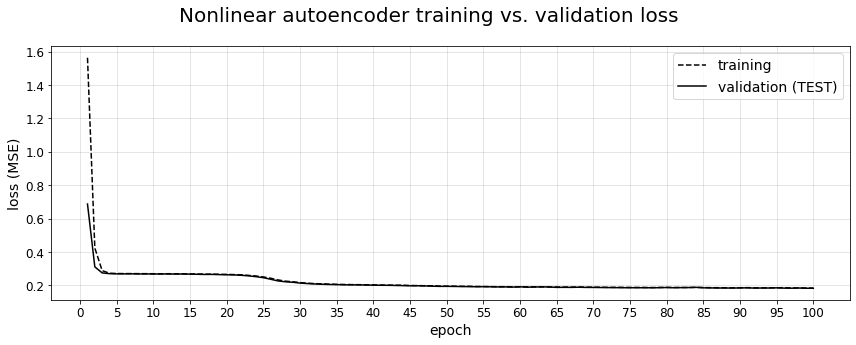

In [316]:
# plot the training vs validation loss 
plot_history(
    ae_history,
    'Nonlinear autoencoder training vs. validation loss',
    loss_type='MSE'
)

In [317]:
# generate AE latent train
ae_latent_train = encoder.predict(embed_array)

In [318]:
plt.scatter(*ae_latent_train.T)

TypeError: scatter() missing 1 required positional argument: 'y'

In [319]:
ae_latent_train

array([[-9.41948223e+00],
       [-8.83400440e+00],
       [-6.41153288e+00],
       [-1.03913946e+01],
       [-8.83629894e+00],
       [-8.70195007e+00],
       [-9.04544926e+00],
       [-5.54716110e+00],
       [-8.41682911e+00],
       [-9.14656353e+00],
       [-8.54279041e+00],
       [-4.84335041e+00],
       [-8.01057243e+00],
       [-7.12332106e+00],
       [-7.85666323e+00],
       [-9.09543228e+00],
       [-5.33049774e+00],
       [-7.28442192e+00],
       [-5.70351219e+00],
       [-4.36263323e+00],
       [-6.18009567e+00],
       [-8.43130302e+00],
       [-9.01882839e+00],
       [-5.58765507e+00],
       [-5.44965315e+00],
       [-7.85669470e+00],
       [-6.00697374e+00],
       [-7.05899096e+00],
       [-7.34585094e+00],
       [-6.14457798e+00],
       [-5.11378956e+00],
       [-6.66557407e+00],
       [-5.12292433e+00],
       [-7.98621559e+00],
       [-7.22735786e+00],
       [-7.37700748e+00],
       [-8.47595882e+00],
       [-6.05268860e+00],
       [-1.0

In [223]:
embed_array.min(), embed_array.max(), embed_array.mean() 

(-6.9190345, 5.7836657, 0.6440112919204679)

In [227]:
embed_array[0].shape

(512,)

In [229]:
ae.predict(embed_array)

array([[-0.10509748,  1.0998034 , -6.1341763 , ..., -0.71162856,
        -0.33539465,  2.1265779 ],
       [-0.10505327,  1.1017897 , -6.135653  , ..., -0.7135573 ,
        -0.33744285,  2.1278462 ],
       [-0.10505161,  1.0806894 , -6.0001225 , ..., -0.70104736,
        -0.33797064,  2.0867004 ],
       ...,
       [-0.10516555,  1.0617092 , -5.89017   , ..., -0.68884414,
        -0.33629674,  2.052545  ],
       [-0.1050196 ,  1.1022749 , -6.1352773 , ..., -0.71412235,
        -0.33805817,  2.127959  ],
       [-0.10493315,  1.1035211 , -6.134317  , ..., -0.71557355,
        -0.33963805,  2.1282477 ]], dtype=float32)

In [230]:
embed_array

array([[-0.13848002,  1.4585834 , -6.7887063 , ..., -0.3438505 ,
         0.27104804,  3.2130494 ],
       [-0.1312232 ,  1.1953796 , -6.7208276 , ..., -0.41062656,
        -0.36766142,  2.9883204 ],
       [ 0.0988148 ,  1.6704051 , -6.5728025 , ..., -1.4026484 ,
        -0.16963036,  1.201116  ],
       ...,
       [-0.26588684,  0.71298146, -6.515095  , ..., -1.5618882 ,
        -1.1403794 ,  1.2628105 ],
       [ 0.04601203,  0.8281939 , -6.618591  , ...,  0.6454799 ,
         0.23046955,  2.7456343 ],
       [ 0.24405985,  1.0486572 , -6.674942  , ..., -0.4831123 ,
        -0.41156986,  2.8691287 ]])

In [167]:
pca = PCA(n_components=2)
embded_pca = pca.fit_transform(embed_array)

In [176]:
pca.explained_variance_ratio_

array([0.27450696, 0.08970017])

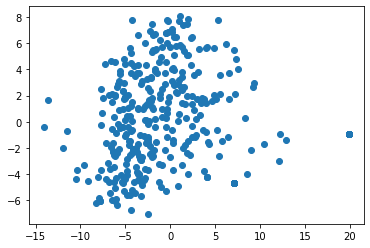

In [170]:
plt.scatter(*embded_pca.T)

In [288]:
# define input dimensions
input_dim = Input(shape=(embed_array.shape[1], 1))

# define encoder layers
x = Conv1D(32, 3, activation='relu', padding='same')(input_dim)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = MaxPooling1D(2, padding='same')(x)
# x = Conv1D(8, 3, activation='relu', padding='same')(x)
# x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(8, 3, activation='relu', padding='same')(x)
x = Flatten()(x)
encoded = Dense(2, activation='')(x)

# define decoder layers
x = Conv1D(8, 3, activation='relu', padding='same')(encoded)
# x = UpSampling1D(2)(x)
# x = Conv1D(8, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
x = Conv1D(32, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='linear', padding='same')(x)

# define cae model
cae = Model(input_dim, decoded)

# set loss, optimizer, and compile model
loss = tf.keras.losses.mean_squared_error
optimizer = Adam(lr=0.0001)

cae.compile(
    loss=loss,
    optimizer=optimizer
)

# print summaries of each model
print('\nTHE CONVOLUTIONAL AUTOENCODER (CAE) MODEL:\n\n')
cae.summary()
print('\n')

ValueError: Input 0 of layer conv1d_64 is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: [None, 2]

In [278]:
embed_shaped = embed_array[:,:,None]

In [280]:
embed_shaped.shape

(378, 512, 1)

In [284]:
%%time



# set my parameters for training the model
verbose = 1
epochs = 20 # note my use of early-stopping to end training at suitable epoch
batch_size = 16

# callback for early stopping when epochs fail to yield val_loss improvements
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=1,
    restore_best_weights=True
)


# Fit model using x_test as validation data and self for measuring loss
cae_history = cae.fit(
    x=embed_shaped,
    y=embed_shaped,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    callbacks=[callback],
    validation_data=(embed_shaped, embed_shaped),
    verbose=verbose
)

Train on 378 samples, validate on 378 samples
Epoch 1/20
378/378 [==============================] - 9s 23ms/sample - loss: 1.8314 - val_loss: 1.8026
Epoch 2/20
378/378 [==============================] - 3s 8ms/sample - loss: 1.7661 - val_loss: 1.7178
Epoch 3/20
378/378 [==============================] - 3s 7ms/sample - loss: 1.6546 - val_loss: 1.5668
Epoch 4/20
378/378 [==============================] - 3s 8ms/sample - loss: 1.4624 - val_loss: 1.3456
Epoch 5/20
378/378 [==============================] - 3s 8ms/sample - loss: 1.2560 - val_loss: 1.1749
Epoch 6/20
378/378 [==============================] - 3s 8ms/sample - loss: 1.1271 - val_loss: 1.0819
Epoch 7/20
 96/378 [======>.......................] - ETA: 2s - loss: 1.0749WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss


KeyboardInterrupt: 